In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
import importlib
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MLP, SetStyle, HistRoutine, net, PET, omnifold
import test_omnifold
from of_transformer import block, embed, input_distributed, net_utils, of_transformer, pair_embed, sequence_trimmer 
import PET

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="5" #odslserv 0123 überprüfen
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="5"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-11-05 11:44:41.791303: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 11:44:41.812269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762339481.830457 1000444 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762339481.835629 1000444 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762339481.852993 1000444 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
TUnfold_incl_path = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/unfolding_SR_Bulk_Final_l_4j_incl_TUnfoldStandalone_OptionA_data_nonClosureAlternative.root'
TUnfold_incl_file = uproot.open(TUnfold_incl_path)

pythia_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_pythia_ttbar.pkl')
herwig_df = pd.read_pickle('/scratch/mjosef/OMNIFOLD_Tutorial/datasets/WbWb_files/bulk_region/df_herwig_ttbar_singletop_DR.pkl')

In [3]:
def MC_data_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    truth_pts  = [df[f'truth_pt{p}']   for p in particle_names]
    truth_etas = [df[f'truth_eta{p}']  for p in particle_names]
    truth_phis = [df[f'truth_phi{p}']  for p in particle_names]
    
    truth_masses = [np.zeros_like(df['truth_ptl1'])] + \
                   [df[f'truth_mb{i}'] for i in range(1, 5)] + \
                   [df[f'truth_mj{i}'] for i in range(1, 7)]

    truth_features = np.stack([truth_pts, truth_etas, truth_phis, truth_masses], axis=-1)
    truth_features = truth_features.transpose(1, 0, 2)

    # Neutrino (truth): use 'truth_met' and 'truth_met_phi'
    truth_met_pt = df['truth_met']
    truth_met_phi = df['truth_metphi']
    zeros_truth = np.zeros_like(truth_met_pt)
    neutrino_truth = np.stack([truth_met_pt, zeros_truth, truth_met_phi, zeros_truth], axis=-1)

    truth_features = np.concatenate([truth_features, neutrino_truth[:, None, :]], axis=1)
    
    return reco_features, truth_features

In [4]:
def subset(df, n_evts, train_test=False):
    
    random_subset = df.sample(n_evts, random_state=42)
    subset_fraction = n_evts / len(df)
    random_subset["eventWeight"] = random_subset['eventWeight'] / subset_fraction # Normalize

    if train_test:
        remaining_df = df.drop(random_subset.index)
        second_subset = remaining_df.sample(n_evts, random_state = 99)
        second_subset['eventWeight'] = second_subset['eventWeight'] / subset_fraction
        
        return random_subset, second_subset

    return random_subset

pythia_train, pythia_test = subset(pythia_df, 1_000_000, train_test=True)
herwig_subset = subset(herwig_df, 1_000_000, train_test=False)

pythia_reco_train, pythia_truth_train = MC_data_shaper(pythia_train)
pythia_reco_test, pythia_truth_test = MC_data_shaper(pythia_test)
herwig_reco, herwig_truth = MC_data_shaper(herwig_subset)

In [5]:
def feature_transform(X):
    pt   = X[..., 0]
    eta  = X[..., 1]
    phi  = X[..., 2]
    mass = X[..., 3]

    # Handle angular variable properly
    sin_phi = np.sin(phi)
    cos_phi = np.cos(phi)

    # Log-transform positive features
    log_pt   = np.log1p(pt)
    log_mass = np.log1p(mass)

    # Stack back into shape (N, P, F)
    features = np.stack([log_pt, eta, phi, log_mass], axis=-1)
    return features

pythia_reco_train = feature_transform(pythia_reco_train)
pythia_truth_train = feature_transform(pythia_truth_train)

pythia_reco_test = feature_transform(pythia_reco_test)
pythia_truth_test = feature_transform(pythia_truth_test)

herwig_reco = feature_transform(herwig_reco)
herwig_truth = feature_transform(herwig_truth)

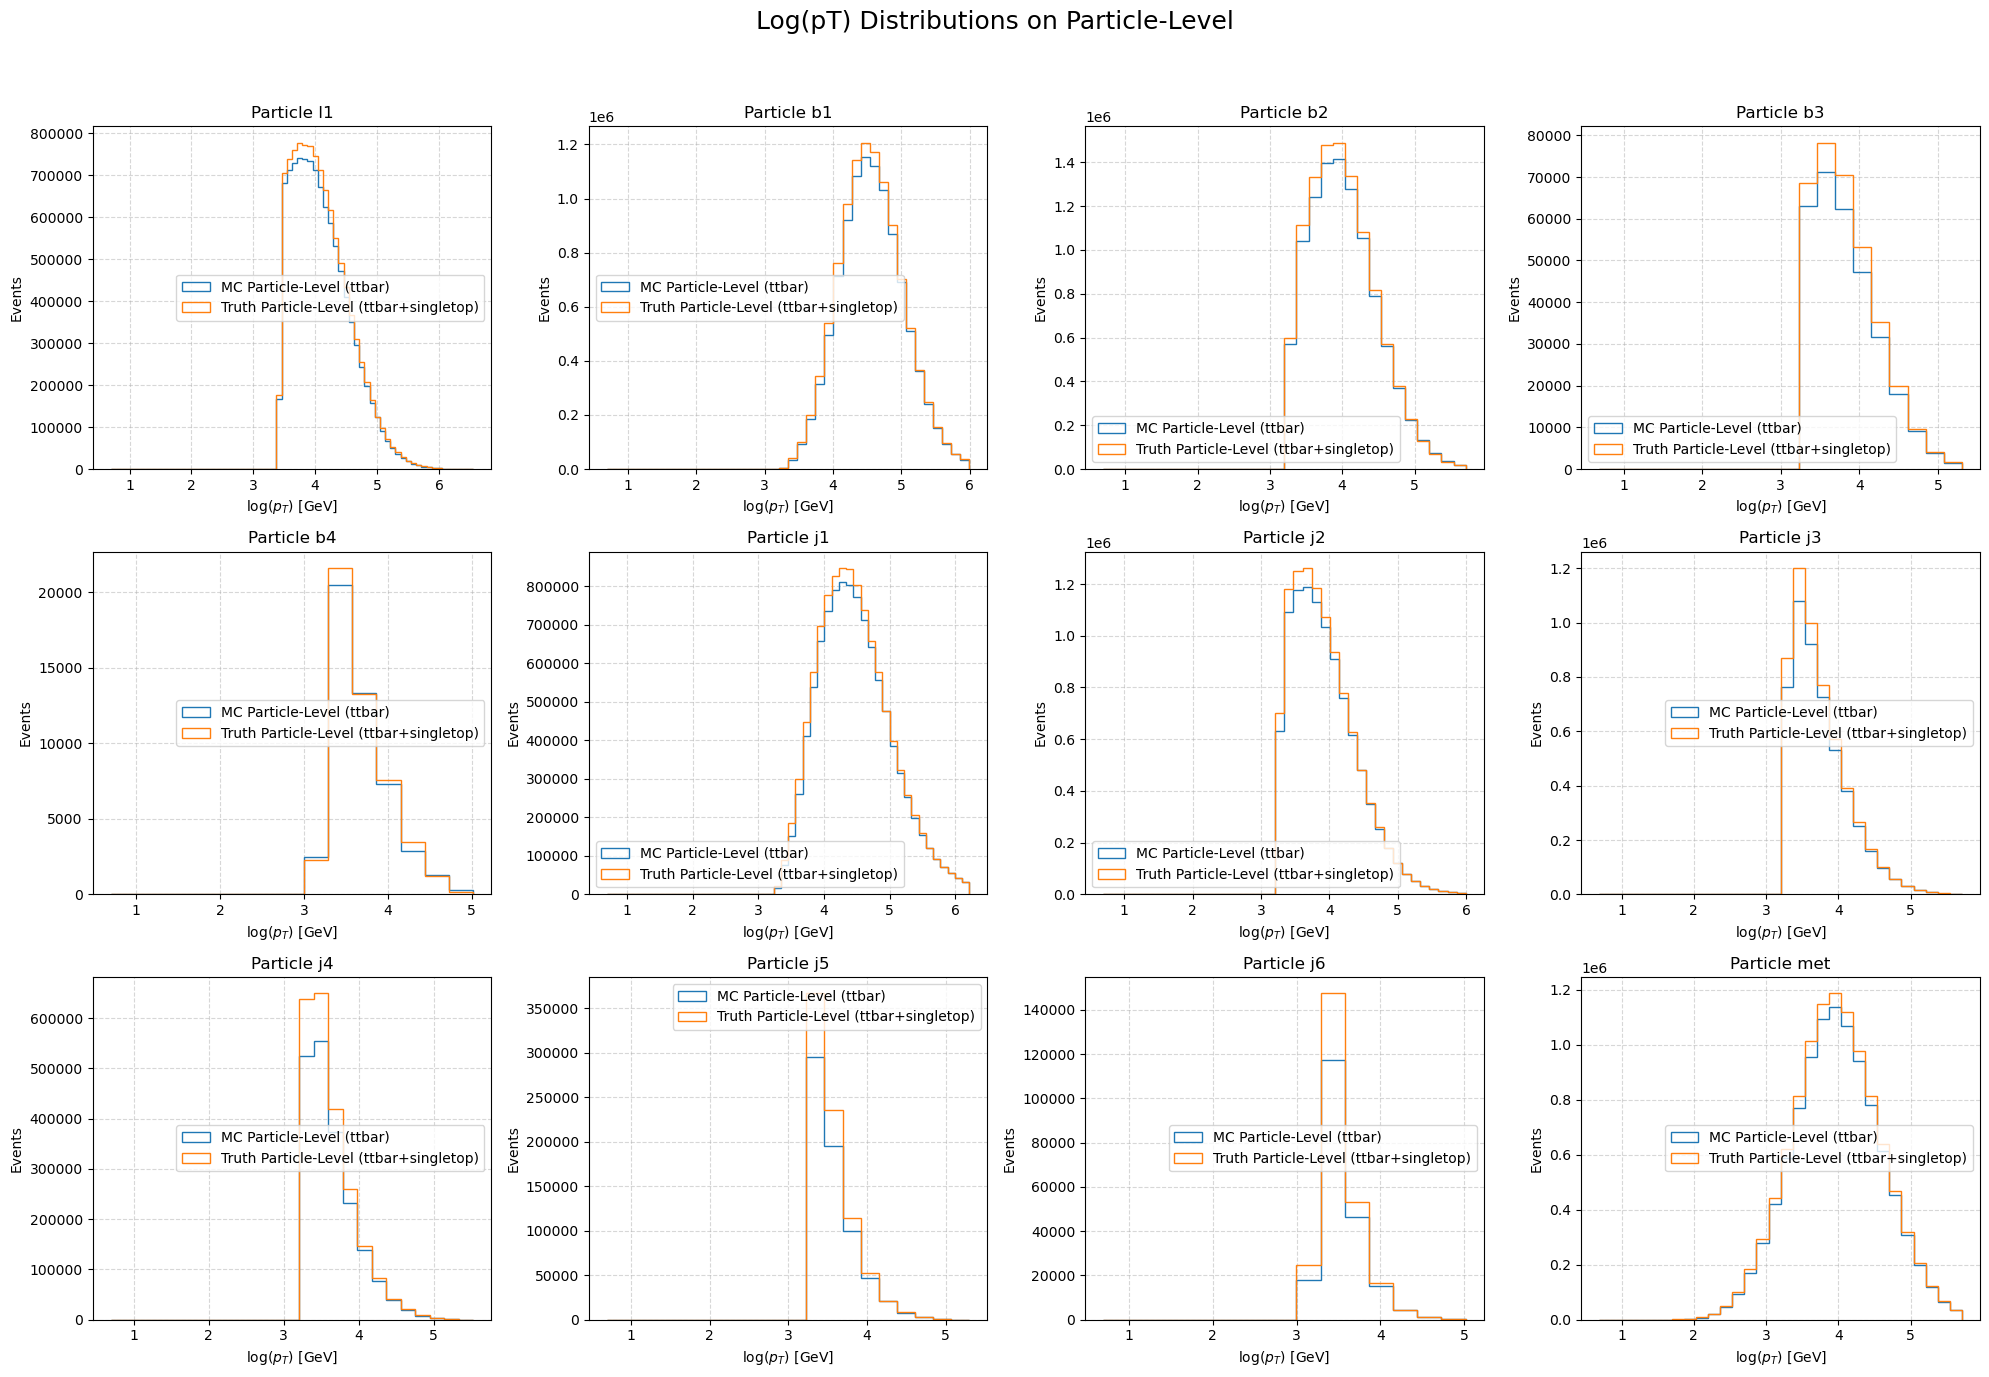

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()

particles = ['l1', 'b1', 'b2', 'b3', 'b4', 
             'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

pt_binning = {
    'l1': np.linspace(np.log1p(1), np.log1p(700), 71),
    'b1': np.linspace(np.log1p(1), np.log1p(400), 41),
    'b2': np.linspace(np.log1p(1), np.log1p(300), 31),
    'b3': np.linspace(np.log1p(1), np.log1p(200), 21),
    'b4': np.linspace(np.log1p(1), np.log1p(150), 16),
    'j1': np.linspace(np.log1p(1), np.log1p(500), 51),
    'j2': np.linspace(np.log1p(1), np.log1p(400), 41),
    'j3': np.linspace(np.log1p(1), np.log1p(300), 31),
    'j4': np.linspace(np.log1p(1), np.log1p(250), 26),
    'j5': np.linspace(np.log1p(1), np.log1p(200), 21),
    'j6': np.linspace(np.log1p(1), np.log1p(150), 16),
    'met': np.linspace(np.log1p(1), np.log1p(300), 31),
}

# --- Loop over all 12 particles ---
for i, pname in enumerate(particles):
    ax = axes[i]
    bins = pt_binning[pname]
    
    mask_pythia = ~np.isnan(pythia_truth_train[:, i, 0])
    mask_herwig = ~np.isnan(herwig_truth[:, i, 0])

    # Plot directly (data is already log(pT))
    ax.hist(
        pythia_truth_train[:, i, 0][mask_pythia],
        weights=(pythia_train['eventWeight'] * pythia_train['pass_particle'])[mask_pythia],
        bins=bins,
        histtype='step',
        label='MC Particle-Level (ttbar)'
    )
    ax.hist(
        herwig_truth[:, i, 0][mask_herwig],
        weights=(herwig_subset['eventWeight'] * herwig_subset['pass_particle'])[mask_herwig],
        bins=bins,
        histtype='step',
        label='Truth Particle-Level (ttbar+singletop)'
    )

    ax.set_title(f"Particle {pname}")
    ax.set_xlabel(r"$\log(p_T)\ \mathrm{[GeV]}$")
    ax.set_ylabel("Events")
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

# Shared title
fig.suptitle("Log(pT) Distributions on Particle-Level", fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


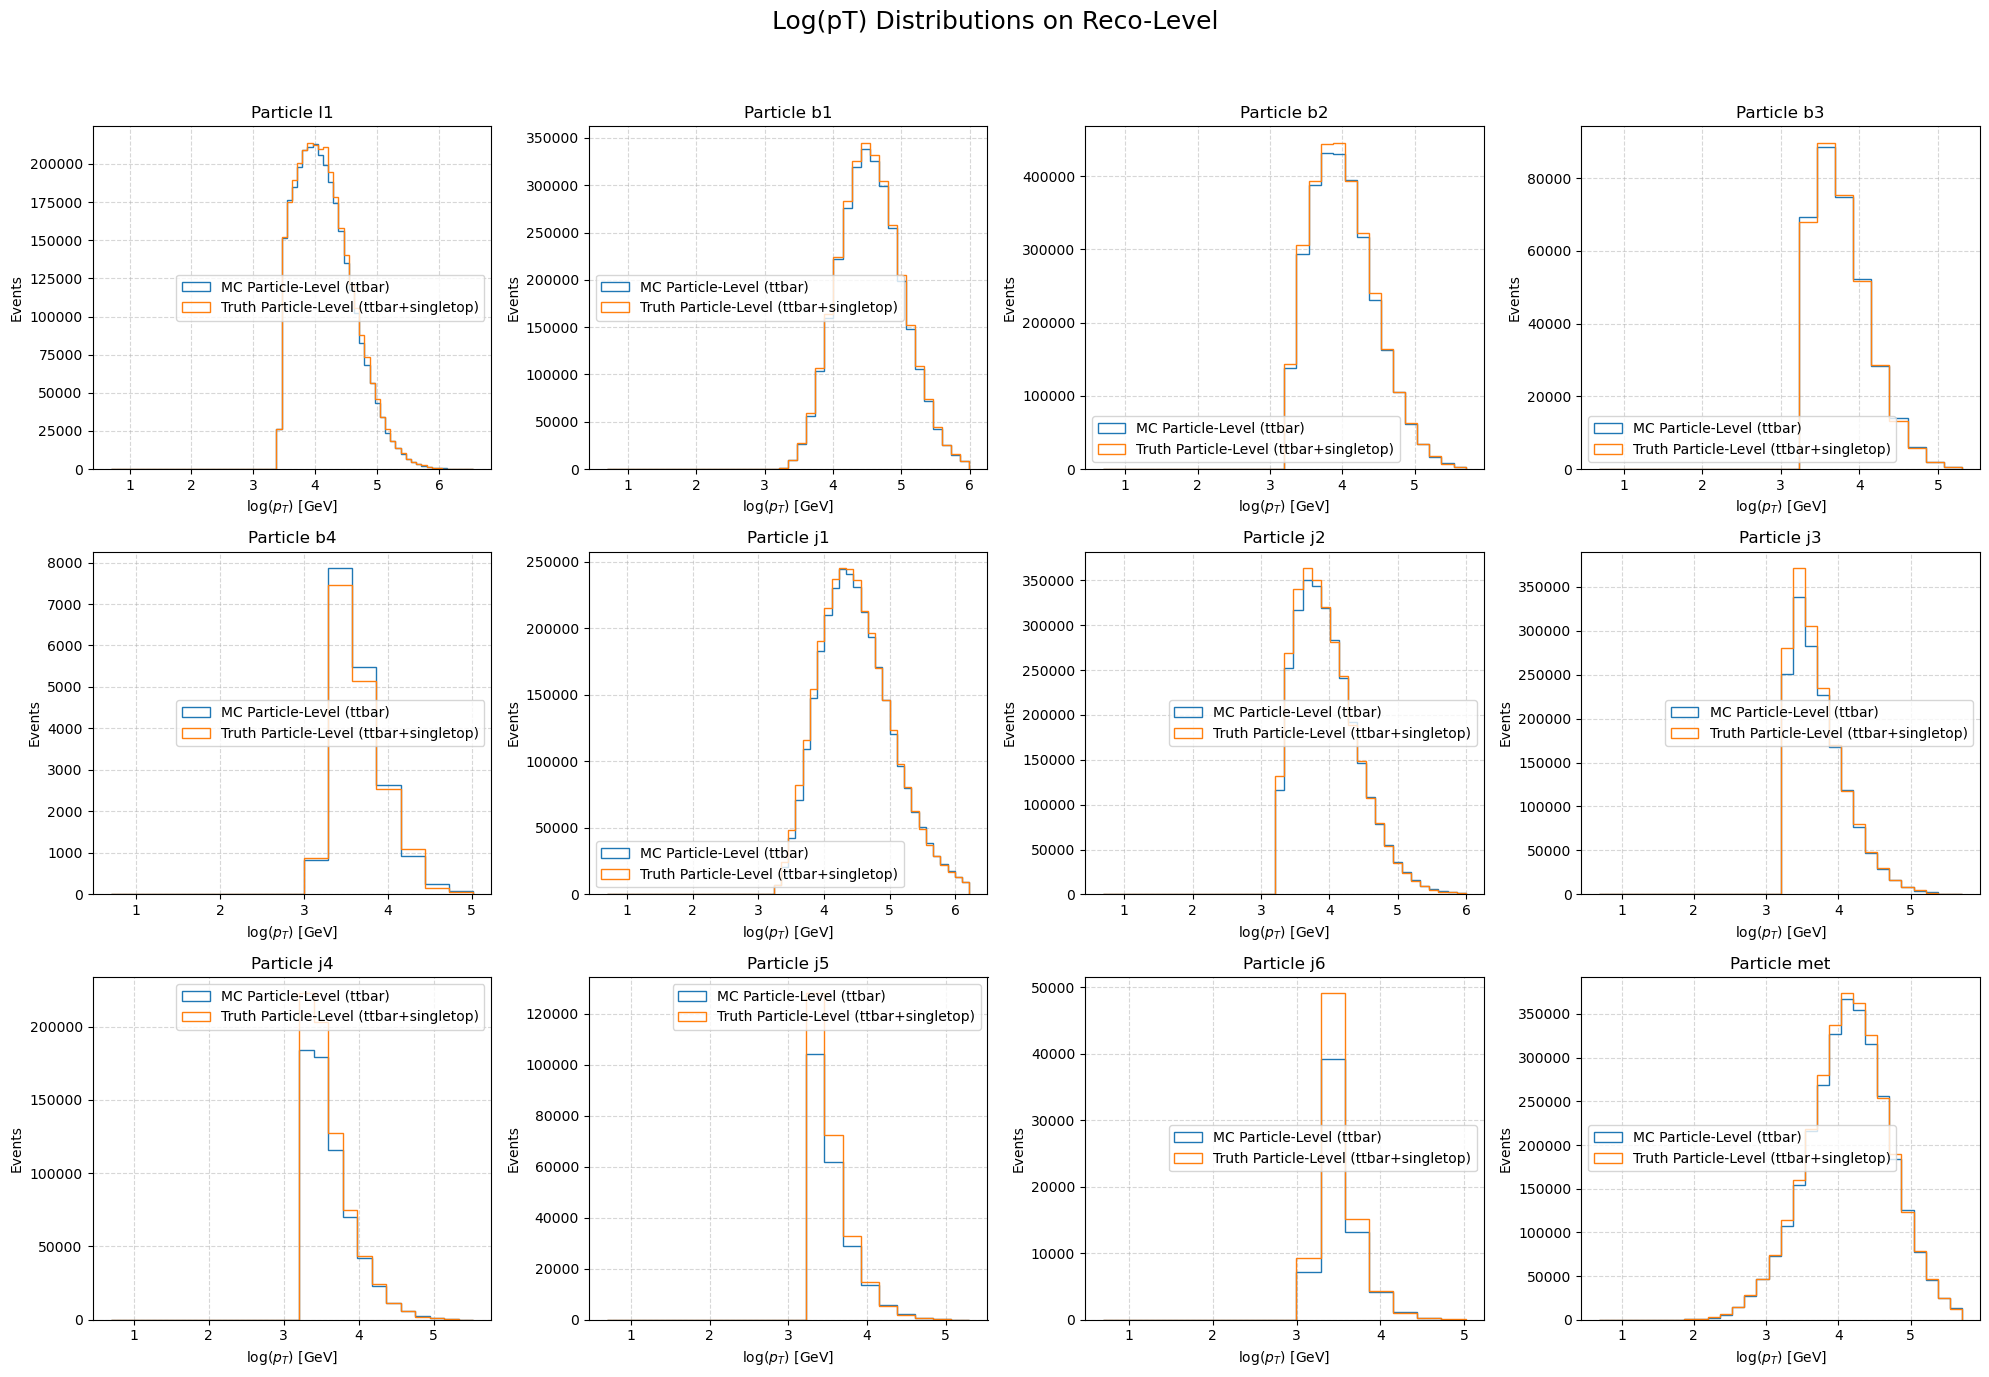

In [7]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()

particles = ['l1', 'b1', 'b2', 'b3', 'b4', 
             'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

pt_binning = {
    'l1': np.linspace(np.log1p(1), np.log1p(700), 71),
    'b1': np.linspace(np.log1p(1), np.log1p(400), 41),
    'b2': np.linspace(np.log1p(1), np.log1p(300), 31),
    'b3': np.linspace(np.log1p(1), np.log1p(200), 21),
    'b4': np.linspace(np.log1p(1), np.log1p(150), 16),
    'j1': np.linspace(np.log1p(1), np.log1p(500), 51),
    'j2': np.linspace(np.log1p(1), np.log1p(400), 41),
    'j3': np.linspace(np.log1p(1), np.log1p(300), 31),
    'j4': np.linspace(np.log1p(1), np.log1p(250), 26),
    'j5': np.linspace(np.log1p(1), np.log1p(200), 21),
    'j6': np.linspace(np.log1p(1), np.log1p(150), 16),
    'met': np.linspace(np.log1p(1), np.log1p(300), 31),
}

# --- Loop over all 12 particles ---
for i, pname in enumerate(particles):
    ax = axes[i]
    bins = pt_binning[pname]
    
    mask_pythia = ~np.isnan(pythia_reco_train[:, i, 0])
    mask_herwig = ~np.isnan(herwig_reco[:, i, 0])

    # Plot directly (data is already log(pT))
    ax.hist(
        pythia_reco_train[:, i, 0][mask_pythia],
        weights=(pythia_train['eventWeight'] * pythia_train['pass_particle'])[mask_pythia],
        bins=bins,
        histtype='step',
        label='MC Particle-Level (ttbar)'
    )
    ax.hist(
        herwig_reco[:, i, 0][mask_herwig],
        weights=(herwig_subset['eventWeight'] * herwig_subset['pass_particle'])[mask_herwig],
        bins=bins,
        histtype='step',
        label='Truth Particle-Level (ttbar+singletop)'
    )

    ax.set_title(f"Particle {pname}")
    ax.set_xlabel(r"$\log(p_T)\ \mathrm{[GeV]}$")
    ax.set_ylabel("Events")
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

# Shared title
fig.suptitle("Log(pT) Distributions on Reco-Level", fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [8]:
class JetScaler:
    def __init__(self, mask_value=0.0):
        self.mask_value = mask_value
        self.scaler = StandardScaler()
    
    def _valid_mask(self, X):
        """
        Returns a boolean mask of jets that are *not* padding.
        Padding jets are those where all 4 features == mask_value.
        """
        return ~np.all(X == self.mask_value, axis=-1)
    
    def fit(self, X):
        """
        Fit the scaler only on valid (non-padded) jets.
        """
        X = np.array(X, dtype=float)
        valid_mask = self._valid_mask(X)
        valid_jets = X[valid_mask]
        self.scaler.fit(valid_jets)
    
    def transform(self, X):
        """
        Transform valid jets, leave padded jets at mask_value.
        """
        X = np.array(X, dtype=float)
        orig_shape = X.shape
        valid_mask = self._valid_mask(X)
        
        X_flat = X.reshape(-1, X.shape[-1])
        X_scaled = np.zeros_like(X_flat)
        
        # Only transform valid jets
        X_scaled[valid_mask.reshape(-1)] = self.scaler.transform(X_flat[valid_mask.reshape(-1)])
        
        # Keep masked jets as mask_value (usually 0)
        X_scaled[~valid_mask.reshape(-1)] = self.mask_value
        
        return X_scaled.reshape(orig_shape)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [9]:
jet_scaler = JetScaler(mask_value=0.0)
jet_scaler.fit(pythia_reco_train)
X_pythia_reco_scaled = jet_scaler.transform(pythia_reco_train)
X_pythia_truth_scaled = jet_scaler.transform(pythia_truth_train)
X_herwig_reco_scaled = jet_scaler.transform(herwig_reco)
X_herwig_truth_scaled = jet_scaler.transform(herwig_truth)

Y_truth_scaled = jet_scaler.transform(pythia_truth_test)

In [10]:
herwig_loader = DataLoader(reco = X_herwig_reco_scaled, gen = X_herwig_truth_scaled, weight = herwig_subset['eventWeight'],
                           pass_reco = herwig_subset['pass_reco'], pass_gen = herwig_subset['pass_particle'], normalize=False)

pythia_loader = DataLoader(reco = X_pythia_reco_scaled, gen = X_pythia_truth_scaled, weight = pythia_train['eventWeight'],
                           pass_reco = pythia_train['pass_reco'], pass_gen = pythia_train['pass_particle'], normalize=False)

testset_loader = DataLoader(reco = pythia_reco_test, gen = pythia_truth_test, weight = pythia_test['eventWeight'],
                           pass_reco = pythia_test['pass_reco'], pass_gen = pythia_test['pass_particle'], normalize=False)

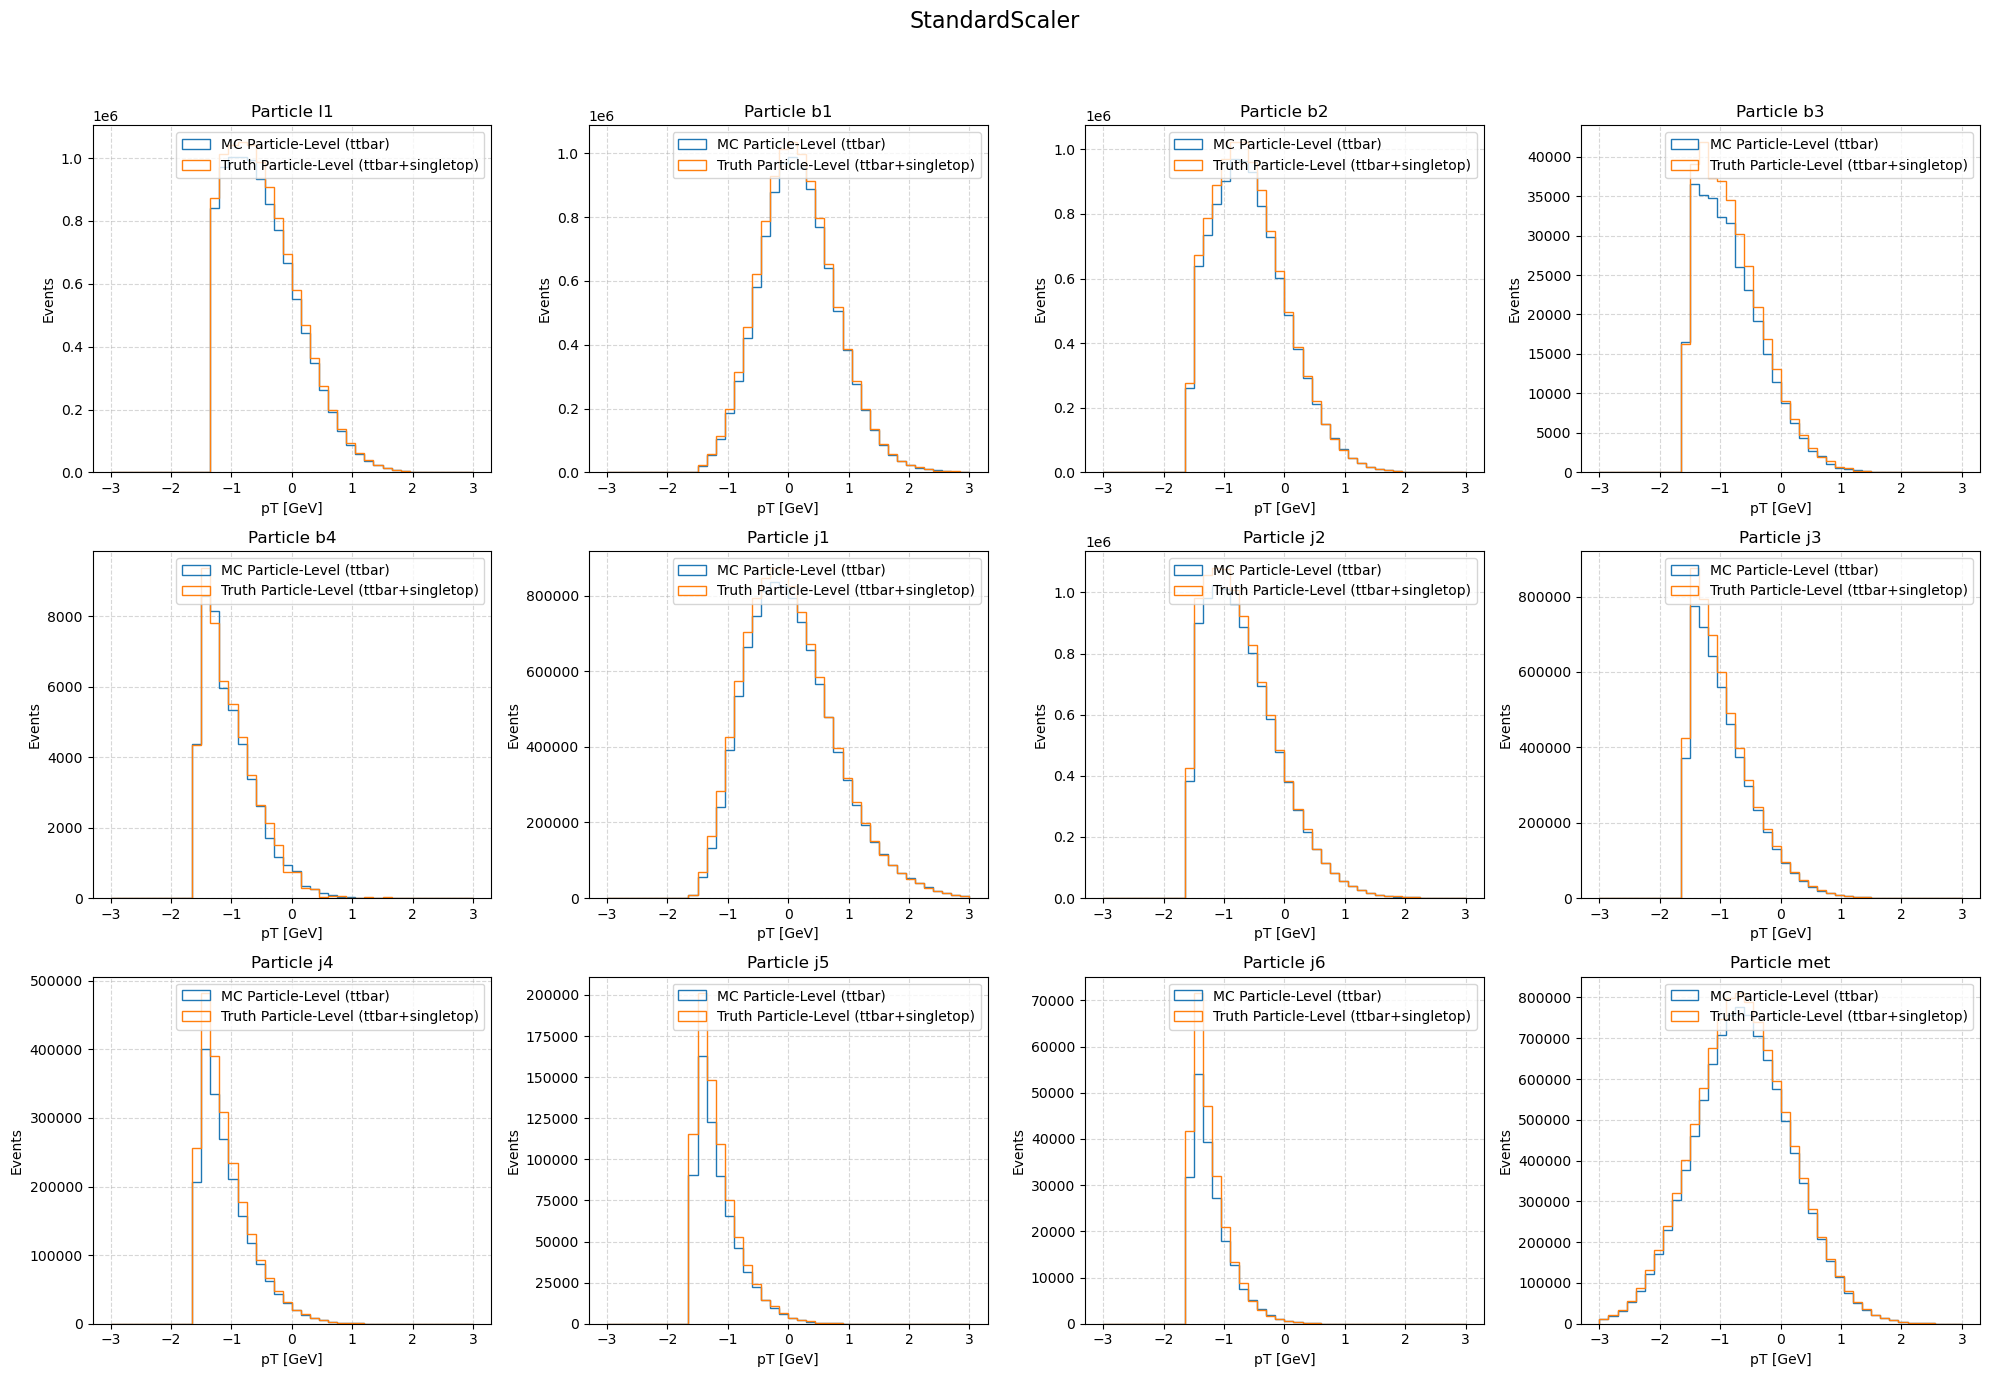

In [11]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

# --- Loop over all 12 particles ---
for i in range(len(particles)):
    ax = axes[i]
    
    # Plot pt distributions
    ax.hist(pythia_loader.gen[:, i, 0][pythia_loader.gen[:, i, 0]!=0], weights=(pythia_loader.weight*pythia_loader.pass_gen)[pythia_loader.gen[:, i, 0]!=0], bins=40, histtype='step', label='MC Particle-Level (ttbar)', range=[-3,3])
    ax.hist(herwig_loader.gen[:, i, 0][herwig_loader.gen[:, i, 0]!=0], weights=(herwig_loader.weight*herwig_loader.pass_gen)[herwig_loader.gen[:, i, 0]!=0], bins=40, histtype='step', label='Truth Particle-Level (ttbar+singletop)', range=[-3,3])
    
    ax.set_title(f"Particle {particles[i]}")
    ax.set_xlabel("pT [GeV]")
    ax.set_ylabel("Events")
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='--', alpha=0.5)
fig.suptitle("StandardScaler", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

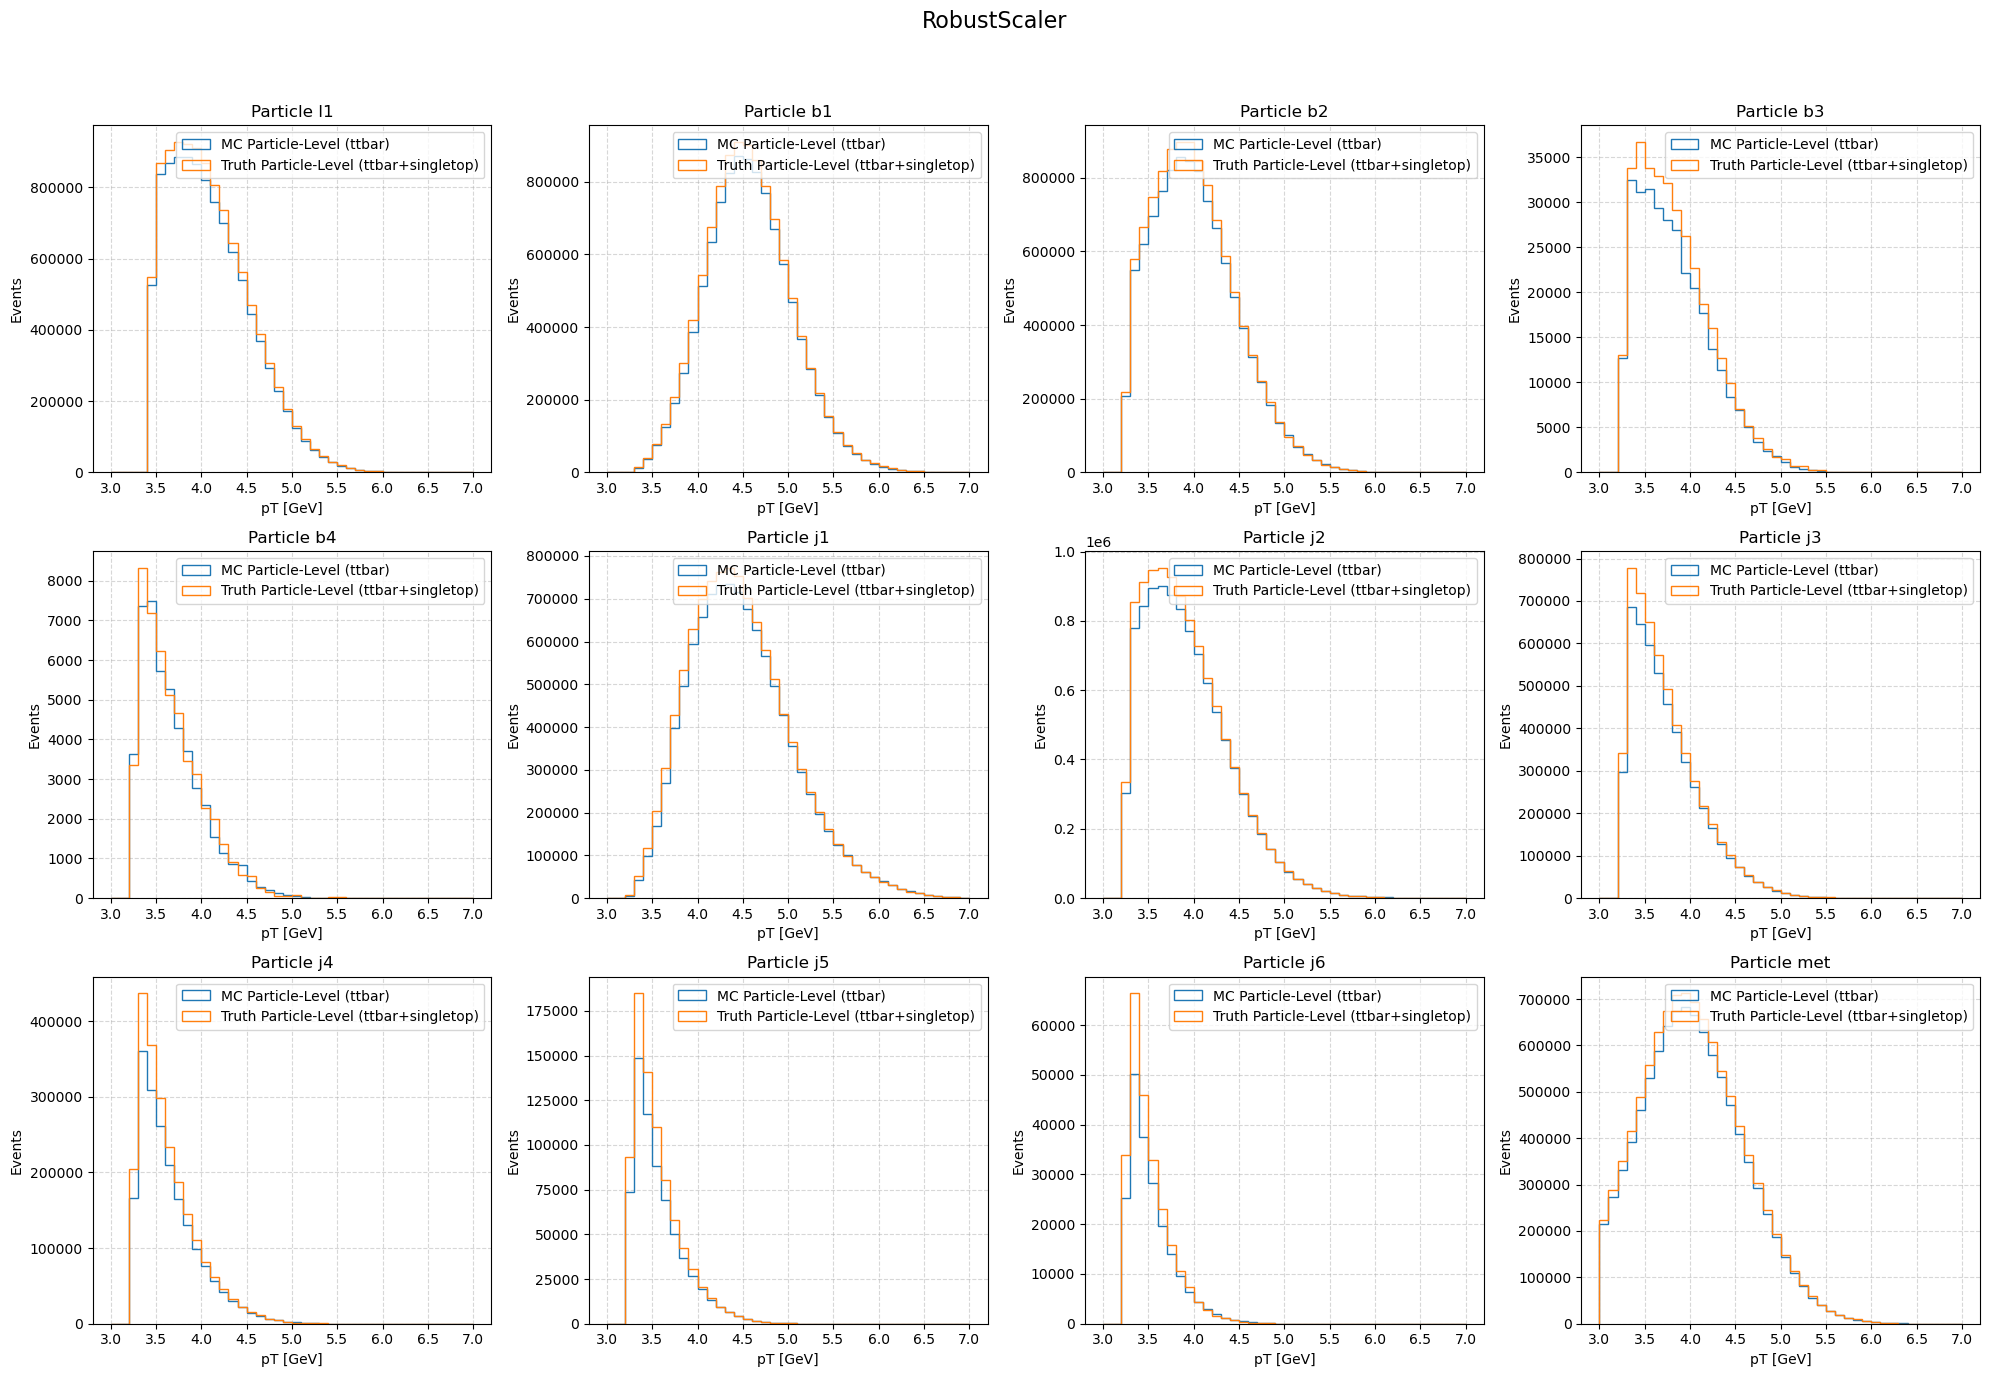

In [38]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

# --- Loop over all 12 particles ---
for i in range(len(particles)):
    ax = axes[i]
    
    # Plot pt distributions
    ax.hist(pythia_loader.gen[:, i, 0][pythia_loader.gen[:, i, 0]!=0], weights=(pythia_loader.weight*pythia_loader.pass_gen)[pythia_loader.gen[:, i, 0]!=0], bins=40, histtype='step', label='MC Particle-Level (ttbar)', range=[3,7])
    ax.hist(herwig_loader.gen[:, i, 0][herwig_loader.gen[:, i, 0]!=0], weights=(herwig_loader.weight*herwig_loader.pass_gen)[herwig_loader.gen[:, i, 0]!=0], bins=40, histtype='step', label='Truth Particle-Level (ttbar+singletop)', range=[3,7])
    
    ax.set_title(f"Particle {particles[i]}")
    ax.set_xlabel("pT [GeV]")
    ax.set_ylabel("Events")
    ax.legend(loc="upper right")
    ax.grid(True, linestyle='--', alpha=0.5)
fig.suptitle("RobustScaler", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [12]:
ndim = 4 # 4 features: pt, eta, phi, mass
npart = 12 # 12 particles: l1, b1-4, j1-6, met

model1 = PET.PET(num_feat = 4, num_part = 12, local=False)
model2 = PET.PET(num_feat = 4, num_part = 12, local=False)

I0000 00:00:1762339780.760616 1000444 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 140840 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:a3:00.0, compute capability: 9.0


In [13]:
omnifold = test_omnifold.MultiFold(
    "closure_pythia_ttbarvsHerwig_WWbb-log",
    model1, # model_reco
    model2, # model_gen
    herwig_loader, # data
    pythia_loader, # MC
    batch_size = 128,
    niter = 3,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_WWbb',
    verbose = True,
    early_stop=5,
    lr = 5e-6,
)

15625 training steps at reco and 15625 steps at gen


In [14]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 2000000, Test events used: 399999
################################################################################
Epoch 1/100


I0000 00:00:1762339790.278995 1003653 service.cc:152] XLA service 0x7f40d40235c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762339790.279047 1003653 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-11-05 11:49:50.402386: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762339791.206981 1003653 cuda_dnn.cc:529] Loaded cuDNN version 90501


   70/12500 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.5601 - loss: 2.8417   

I0000 00:00:1762339796.537213 1003653 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.5628 - loss: 2.8234 - val_accuracy: 0.5636 - val_loss: 2.8051 - learning_rate: 5.0000e-06
Epoch 2/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.5631 - loss: 2.8144 - val_accuracy: 0.5636 - val_loss: 2.8039 - learning_rate: 5.0000e-06
Epoch 3/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.5633 - loss: 2.8135 - val_accuracy: 0.5636 - val_loss: 2.8021 - learning_rate: 5.0000e-06
Epoch 4/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.5629 - loss: 2.8204 - val_accuracy: 0.5636 - val_loss: 2.7998 - learning_rate: 5.0000e-06
Epoch 5/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.5632 - loss: 2.8130 - val_accuracy: 0.5636 - val_loss: 2.7963 - learning_rate: 5.0000e-06
Epoch 6/100
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.5633 - loss: 2.8173 - val_accuracy: 0.5636 - val_loss: 2.7925 - learning_rate: 5.0000e-06
Epoch 7/100
12500/12500 ━━━━━━━━━━━━━━━━

In [36]:
unfolded_weights  = omnifold.reweight(Y_truth_scaled,omnifold.model2,batch_size=1000)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   


In [16]:
np.save("/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_WWbb/unfolded_weights.npy", unfolded_weights)

In [17]:
unfolded_weights = np.load("/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_WWbb/unfolded_weights.npy")

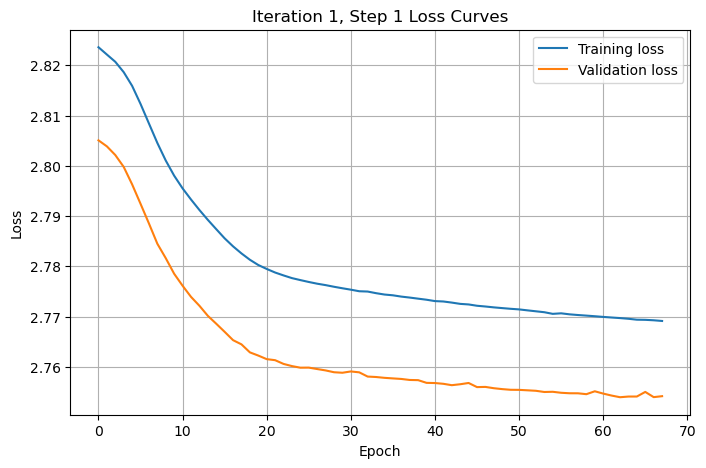

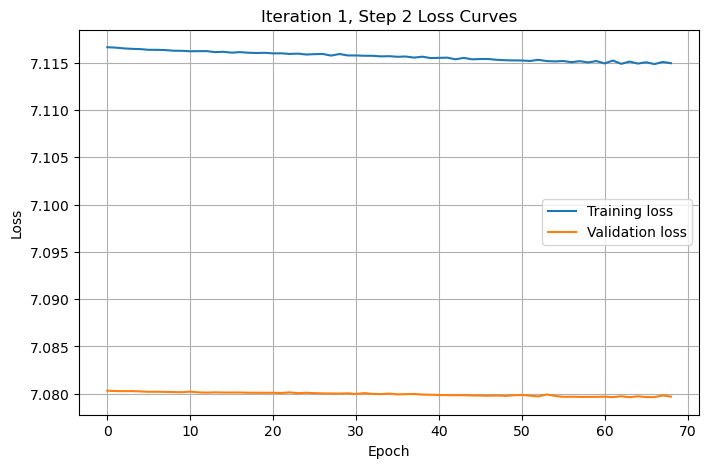

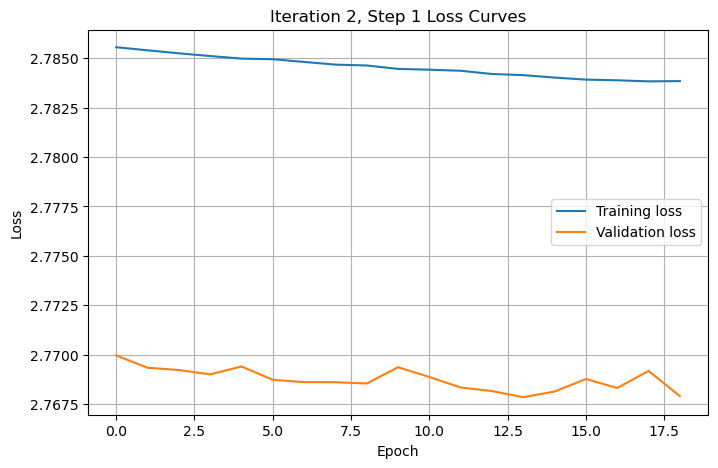

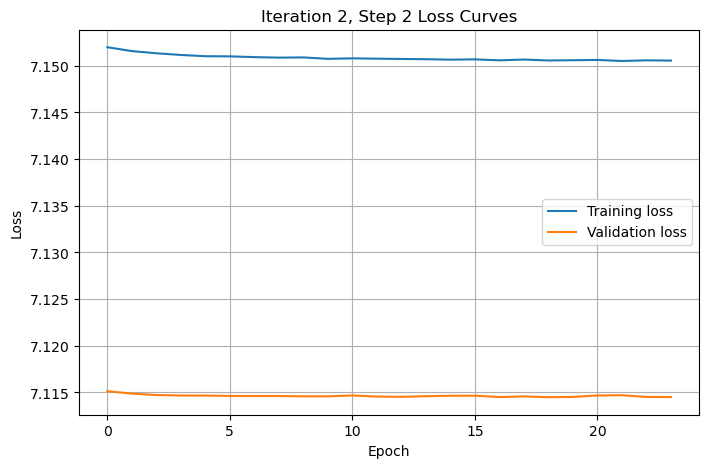

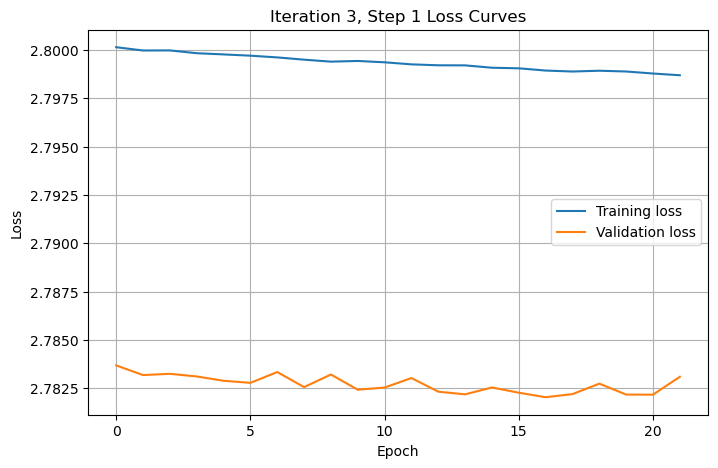

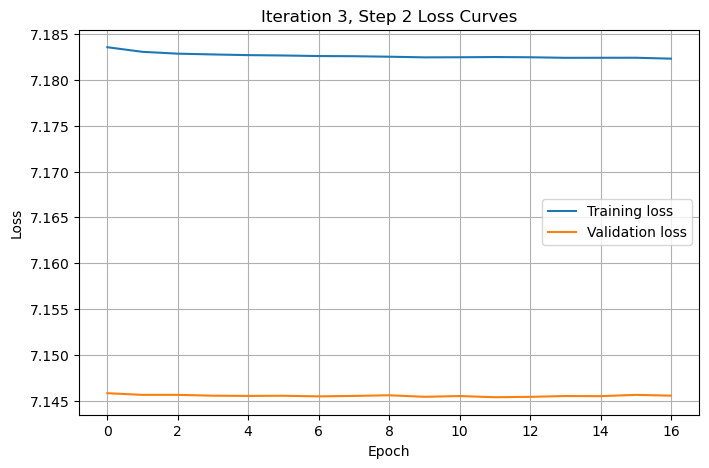

In [18]:
import pickle
import os
# Set these to your parameters
weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_WWbb'      
name = "closure_pythia_ttbarvsHerwig_WWbb-log"     
niter = 3                       
n_ensemble = 1                  
# Loop over iterations and steps
for iteration in range(niter):
    for stepn in [1, 2]:
        plt.figure(figsize=(8,5))
        plt.title(f"Iteration {iteration+1}, Step {stepn} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        all_loss = []
        all_val_loss = []

        for e in range(n_ensemble):
            # Construct pickle file name
            model_file = f"{weights_folder}/OmniFold_{name}_iter{iteration}_step{stepn}"
            if n_ensemble > 1:
                model_file += f"_ensemble{e}"
            model_file += ".weights.h5"
            history_file = model_file.replace(".weights.h5", ".pkl")
            
            # Load history
            if os.path.exists(history_file):
                with open(history_file, "rb") as f:
                    history = pickle.load(f)
                all_loss.append(history['loss'])
                all_val_loss.append(history['val_loss'])
            else:
                print(f"History file not found: {history_file}")

        # Average over ensembles if multiple
        avg_loss = np.mean(all_loss, axis=0)
        avg_val_loss = np.mean(all_val_loss, axis=0)

        plt.plot(avg_loss, label='Training loss')
        plt.plot(avg_val_loss, label='Validation loss')
        plt.legend()
        plt.grid(True)
        plt.show()


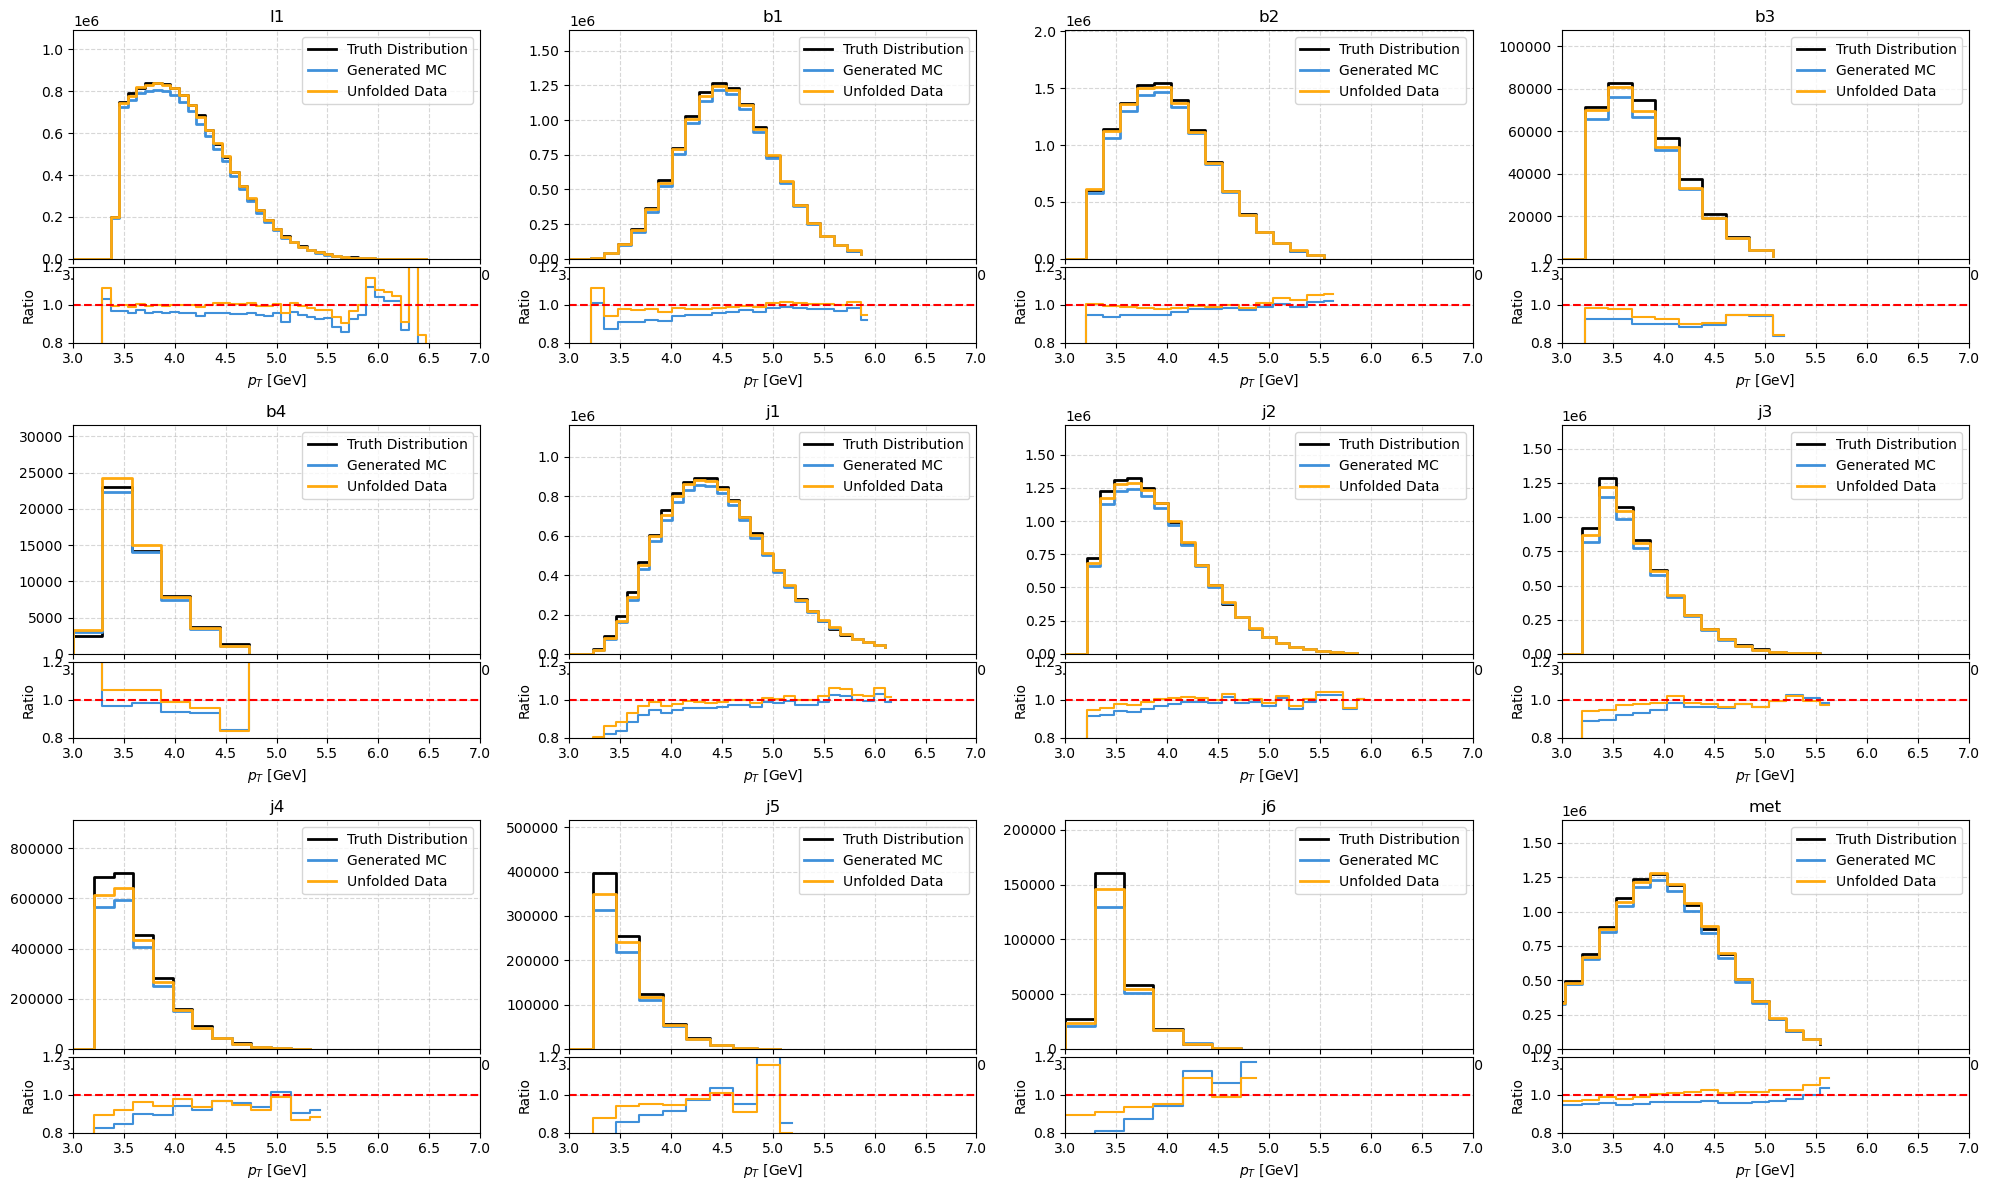

In [22]:
pt_binning = {
    'l1': np.linspace(np.log1p(1), np.log1p(700), 71),
    'b1': np.linspace(np.log1p(1), np.log1p(400), 41),
    'b2': np.linspace(np.log1p(1), np.log1p(300), 31),
    'b3': np.linspace(np.log1p(1), np.log1p(200), 21),
    'b4': np.linspace(np.log1p(1), np.log1p(150), 16),
    'j1': np.linspace(np.log1p(1), np.log1p(500), 51),
    'j2': np.linspace(np.log1p(1), np.log1p(400), 41),
    'j3': np.linspace(np.log1p(1), np.log1p(300), 31),
    'j4': np.linspace(np.log1p(1), np.log1p(250), 26),
    'j5': np.linspace(np.log1p(1), np.log1p(200), 21),
    'j6': np.linspace(np.log1p(1), np.log1p(150), 16),
    'met': np.linspace(np.log1p(1), np.log1p(300), 31),
}

def plot_pt_subplot(ax_main, ax_ratio, data_dict, weights_dict, bins):
    x_centers = 0.5 * (bins[1:] + bins[:-1])
    
    # Reference histogram: first entry
    ref_name = list(data_dict.keys())[0]
    ref_counts, _ = np.histogram(data_dict[ref_name], bins=bins, weights=weights_dict[ref_name])
    
    maxy = 0
    colors = ['black', '#3f90da', '#ffa90e', '#bd1f01']  # adjust as needed
    
    for i, (label, values) in enumerate(data_dict.items()):
        counts, _ = np.histogram(values, bins=bins, weights=weights_dict[label])
        ax_main.step(bins[:-1], counts, where='post', color=colors[i], label=label, linewidth=2)
        maxy = max(maxy, counts.max())
        
        if ax_ratio is not None and i > 0:  # skip reference
            ratio = np.divide(counts, ref_counts, out=np.zeros_like(counts), where=ref_counts!=0)
            ax_ratio.step(x_centers, ratio, where='mid', color=colors[i], label=f"{label}/{ref_name}")
    
    ax_main.set_ylim(0, 1.3*maxy)
    ax_main.set_xlim(3,7)
    ax_main.grid(True, linestyle='--', alpha=0.5)
    ax_main.legend(fontsize=10)
    if ax_ratio is not None:
        ax_ratio.axhline(1.0, color='r', linestyle='--')
        ax_ratio.set_ylim(0.8, 1.2)
        ax_ratio.set_xlabel(r"$p_T$ [GeV]")
        ax_ratio.set_ylabel("Ratio")
        ax_ratio.grid(True, linestyle='--', alpha=0.5)

# --- Create figure with 3x4 subplots ---
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()
mask_pythia = ~np.isnan(pythia_truth_test[:, i, 0])
mask_herwig = ~np.isnan(herwig_truth[:, i, 0])

for i, pname in enumerate(particles[:12]):
    # Prepare data
    data_dict = {
        'Truth Distribution': herwig_truth[:, i, 0][~np.isnan(herwig_truth[:, i, 0])],
        'Generated MC': pythia_truth_test[:, i, 0][~np.isnan(pythia_truth_test[:, i, 0])],
        'Unfolded Data': pythia_truth_test[:, i, 0][~np.isnan(pythia_truth_test[:, i, 0])],
    }
    weight_dict = {
        'Truth Distribution': herwig_subset['eventWeight'][~np.isnan(herwig_truth[:, i, 0])],
        'Generated MC': pythia_test['eventWeight'][~np.isnan(pythia_truth_test[:, i, 0])],
        'Unfolded Data': (unfolded_weights * pythia_test['eventWeight'])[~np.isnan(pythia_truth_test[:, i, 0])],
    }
    
    # Create a small inset for ratio
    # Here we just stack main+ratio manually inside the same subplot
    # Define height ratios
    gs = axes[i].get_gridspec()
    for ax in axes[i].get_shared_x_axes().get_siblings(axes[i]):
        ax.remove()
    
    from matplotlib.gridspec import GridSpecFromSubplotSpec
    sub_gs = GridSpecFromSubplotSpec(2, 1, height_ratios=[3,1], subplot_spec=gs[i], hspace=0.05)
    ax_main = fig.add_subplot(sub_gs[0])
    ax_ratio = fig.add_subplot(sub_gs[1], sharex=ax_main)
    
    plot_pt_subplot(ax_main, ax_ratio, data_dict, weight_dict, pt_binning[pname])
    
    ax_main.set_title(pname)

plt.tight_layout()
plt.show()


In [ ]:
weights_folder = '/scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_WWbb' 
omnifold_name  = "closure_pythia_ttbarvsHerwig_WWbb-log"
n_iterations   = 3
n_ensembles    = 1

# --------------------------------------------------------
# LOAD WEIGHTS FUNCTION
def load_unfolded_weights(iteration, stepn, ensemble=0):
    model_name = f"{weights_folder}/OmniFold_{omnifold_name}_iter{iteration}_step{stepn}"
    if n_ensembles > 1:
        model_name += f"_ensemble{ensemble}"
    model_name += ".weights.h5"

    if not os.path.exists(model_name):
        print(f"❌ Missing: {model_name}")
        return None

    print(f"✅ Loading weights: {model_name}")

    my_model = omnifold.model2

    # 🧩 Ensure model is built before loading weights
    _ = my_model.build(input_shape=(None, 12, 4))    # or use my_model.build(input_shape=(None, Y_truth_scaled.shape[1]))

    my_model.load_weights(model_name)
    unfolded_weights = my_model.reweight(Y_truth_scaled, batch_size=1000).flatten()
    #FIXME: def reweight():

    return unfolded_weights


# --------------------------------------------------------
# SMALL HELPER FUNCTION FOR EACH SUBPLOT
# --------------------------------------------------------
def plot_pt_subplot(ax_main, ax_ratio, data_dict, weights_dict, bins):
    x_centers = 0.5 * (bins[1:] + bins[:-1])
    
    # Reference histogram: first entry
    ref_name = list(data_dict.keys())[0]
    ref_counts, _ = np.histogram(data_dict[ref_name], bins=bins, weights=weights_dict[ref_name])
    
    maxy = 0
    colors = ['black', '#3f90da', '#ffa90e', '#bd1f01']  # adjust as needed
    
    for i, (label, values) in enumerate(data_dict.items()):
        counts, _ = np.histogram(values, bins=bins, weights=weights_dict[label])
        ax_main.step(bins[:-1], counts, where='post', color=colors[i], label=label, linewidth=2)
        maxy = max(maxy, counts.max())
        
        if ax_ratio is not None and i > 0:  # skip reference
            ratio = np.divide(counts, ref_counts, out=np.zeros_like(counts), where=ref_counts!=0)
            ax_ratio.step(x_centers, ratio, where='mid', color=colors[i], label=f"{label}/{ref_name}")
    
    ax_main.set_ylim(0, 1.3*maxy)
    ax_main.set_xlim(3,7)
    ax_main.grid(True, linestyle='--', alpha=0.5)
    ax_main.legend(fontsize=10)
    if ax_ratio is not None:
        ax_ratio.axhline(1.0, color='r', linestyle='--')
        ax_ratio.set_ylim(0.8, 1.2)
        ax_ratio.set_xlabel(r"$p_T$ [GeV]")
        ax_ratio.set_ylabel("Ratio")
        ax_ratio.grid(True, linestyle='--', alpha=0.5)


# --------------------------------------------------------
# PLOT FOR EACH ITERATION
# --------------------------------------------------------
def plot_iteration(iteration, unfolded_weights):
    fig = plt.figure(figsize=(20, 12))
    outer_gs = fig.add_gridspec(3, 4, wspace=0.3, hspace=0.3)

    for i, pname in enumerate(particles[:12]):
        sub_gs = GridSpecFromSubplotSpec(2, 1, height_ratios=[3,1],
                                         subplot_spec=outer_gs[i], hspace=0.05)
        ax_main = fig.add_subplot(sub_gs[0])
        ax_ratio = fig.add_subplot(sub_gs[1], sharex=ax_main)

        data_dict = {
        'Truth Distribution': herwig_truth[:, i, 0][~np.isnan(herwig_truth[:, i, 0])],
        'Generated MC': pythia_truth_test[:, i, 0][~np.isnan(pythia_truth_test[:, i, 0])],
        'Unfolded Data': pythia_truth_test[:, i, 0][~np.isnan(pythia_truth_test[:, i, 0])],
        }
        weight_dict = {
            'Truth Distribution': herwig_subset['eventWeight'][~np.isnan(herwig_truth[:, i, 0])],
            'Generated MC': pythia_test['eventWeight'][~np.isnan(pythia_truth_test[:, i, 0])],
            'Unfolded Data': (unfolded_weights * pythia_test['eventWeight'])[~np.isnan(pythia_truth_test[:, i, 0])],
        }

        plot_pt_subplot(ax_main, ax_ratio, data_dict, weight_dict, pt_binning[pname])
        ax_main.set_title(pname, fontsize=10)

    plt.tight_layout()
    plt.savefig(f"{weights_folder}/gridplot_iter{iteration+1}.png", dpi=150)
    plt.close()
    print(f"📊 Saved 3×4 grid plot for iteration {iteration+1}")


# --------------------------------------------------------
# MAIN LOOP
# --------------------------------------------------------
for i in range(n_iterations):
    unfolded_weights = load_unfolded_weights(i, stepn=2)
    if unfolded_weights is not None:
        plot_iteration(i, unfolded_weights)


✅ Loading weights: /scratch/mjosef/Unfolding/omnifold/weights_pythia_ttbarvsHerwig_WWbb/OmniFold_closure_pythia_ttbarvsHerwig_WWbb-log_iter0_step2.weights.h5


/opt/conda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 92 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


AttributeError: 'PET' object has no attribute 'reweight'

In [33]:
def convert_to4vector(array):
    """
    Convert an array of shape (n_events, n_particles, 4) with (pt, eta, phi, m)
    to an array of shape (n_events, n_particles, 4) with (E, px, py, pz).
    """
    log_pt = array[:, 0]
    eta = array[:, 1]
    phi = array[:, 2]
    log_m = array[:, 3]

    pt = np.expm1(log_pt)
    m = np.expm1(log_m)

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(px**2 + py**2 + pz**2 + m**2)

    return np.stack((E, px, py, pz), axis=-1)

def calculate_mass(array):
    """
    Calculate the invariant mass of the system represented by the input array.
    The input array should have shape (n_events, n_particles, 4) with (E, px, py, pz).
    Returns an array of shape (n_events,) with the invariant mass for each event.
    """
    E = array[:, 0]
    px = array[:, 1]
    py = array[:, 2]
    pz = array[:, 3]

    mass_squared = E**2 - (px**2 + py**2 + pz**2)
    mass_squared = np.maximum(mass_squared, 0)  # Avoid negative values due to numerical issues
    return np.sqrt(mass_squared)

def W_candidate(array):
    # Hard coded W mass
    W_mass = 80.379

    # leading and subleading jets (indices 5 and 6)
    leading_jet = array[:, 5, :]
    subleading_jet = array[:, 6, :]
    leading_jet_4vec = convert_to4vector(leading_jet)
    subleading_jet_4vec = convert_to4vector(subleading_jet)
    combined_4vec = leading_jet_4vec + subleading_jet_4vec

    # Calculate masses
    mass_leading = calculate_mass(leading_jet_4vec)
    mass_subleading = calculate_mass(subleading_jet_4vec)
    mass_combined = calculate_mass(combined_4vec)

    # Stack all masses and 4-vectors: shape (n_events, 3)
    all_masses = np.stack([mass_leading, mass_subleading, mass_combined], axis=1)
    all_4vecs = np.stack([leading_jet_4vec, subleading_jet_4vec, combined_4vec], axis=1)

    # Find index of mass closest to W_mass for each event
    idx_closest = np.argmin(np.abs(all_masses - W_mass), axis=1)

    # Select 4-vector for each event
    selected_4vec = all_4vecs[np.arange(len(array)), idx_closest, :]

    return selected_4vec

def min_mbl(array):
    # b-jet indices: 1, 2
    b_jets = [array[:, i, :] for i in range(1,3)]
    lepton = array[:, 0, :]

    b_jet_4vecs = [convert_to4vector(b_jet) for b_jet in b_jets]
    lepton_4vec = convert_to4vector(lepton)

    mbl_values = []
    for b_jet_4vec in b_jet_4vecs:
        combined_4vec = b_jet_4vec + lepton_4vec
        mbl = calculate_mass(combined_4vec)
        mbl_values.append(mbl)

    mbl_stack = np.stack(mbl_values, axis=1)  # shape (n_events, 2)
    return np.min(mbl_stack, axis=1)  # shape (n_events,)

In [ ]:
from omnifold import utils

(<Figure size 900x900 with 2 Axes>, <Axes: ylabel='# Events'>)

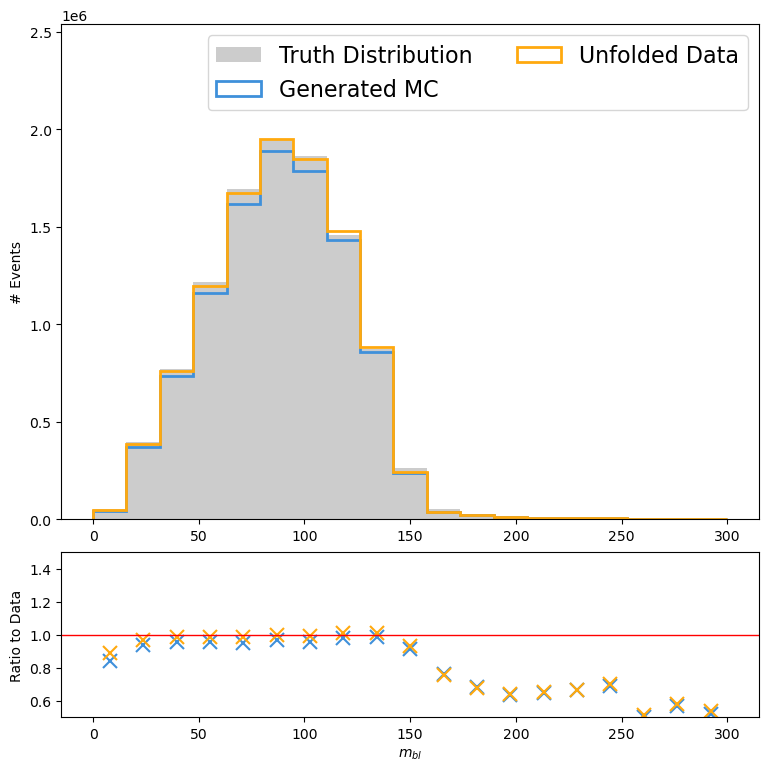

In [38]:
data_dict_mbl = {
        'Truth Distribution': min_mbl(herwig_truth),
        'Generated MC': min_mbl(pythia_truth_test),
        'Unfolded Data': min_mbl(pythia_truth_test),
    }
weight_dict_mbl = {
        'Truth Distribution': herwig_subset['eventWeight']*herwig_subset['pass_particle'],
        'Generated MC': pythia_test['eventWeight']*pythia_test['pass_particle'],
        'Unfolded Data': (unfolded_weights * pythia_test['eventWeight'])*pythia_test['pass_particle'],
    }

HistRoutine(
        data_dict_mbl,
        f"$m_{{bl}}$",
        ylabel="# Events",
        reference_name='Truth Distribution',
        weights=weight_dict_mbl,
        plot_ratio=True,
        binning=np.linspace(0,300, 20),
    )